In [ ]:
### K- means Clustering 
## Translated from R to python to be able to get the temperatures composites
## EDIT 10/ 23 : ChatGPT was used to translate parts of the code from R to python
## EDIT 10/ 23 : Basis for this work is based on scientific paper: 
## EDIT 10/ 23 : "Cold-air outbreaks in the continental US: Connections with stratospheric variations"- Agel et. al 20225

In [3]:
import dask.array as da
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import math
import datetime
import cftime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import colormaps as cmaps


import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from itertools import groupby
from datetime import datetime
from datetime import timedelta
import matplotlib.patches as mpatches
import cartopy.feature as cfeature

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates

from netCDF4 import Dataset
import sys
from scipy.interpolate import interp1d
import time
from dask.diagnostics import ProgressBar
from itertools import groupby

In [4]:
file4 ='/scratch/kbarrag/CLIM763/Data/era5.t2m.cao_ones.19792019.nc'
era5_ones = xr.open_dataset(file4 )
era5_ones

<xarray.Dataset>
Dimensions:    (time: 673, latitude: 81, longitude: 73)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-03 1979-01-04 ... 2019-02-02
  * longitude  (longitude) float32 -85.0 -84.75 -84.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 29.5 29.25 29.0
Data variables:
    t2m        (time, latitude, longitude) int64 ...

In [5]:
file ='/scratch/kbarrag/CLIM763/Data/era5.z10.19792019.coarse.nc'
ds = xr.open_dataset(file )
ds = ds/9.81 /10
ds


<xarray.Dataset>
Dimensions:       (time: 14975, latitude: 96, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
Data variables:
    geopotential  (time, latitude, longitude) float32 2.825e+03 ... 3.073e+03

In [6]:
file1 ='/scratch/kbarrag/CLIM763/Data/era5.t2m.4xs.19792019.coarse.nc'
ds1 = xr.open_dataset(file1)
ds1 = ds1
ds1

<xarray.Dataset>
Dimensions:         (time: 14975, latitude: 96, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude        (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude       (longitude) float32 -179.6 -178.6 -177.6 ... 178.4 179.4
Data variables:
    2m_temperature  (time, latitude, longitude) float32 ...

In [8]:
z10_climo = ds.groupby('time.dayofyear').mean(dim = 'time')
z10_anom = ds.groupby('time.dayofyear') - z10_climo
z10_anom

<xarray.Dataset>
Dimensions:       (time: 14975, latitude: 96, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
    dayofyear     (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    geopotential  (time, latitude, longitude) float32 -47.24 -47.24 ... -8.549

In [9]:
t2m_climo = ds1.groupby('time.dayofyear').mean(dim = 'time')
t2m_anom = ds1.groupby('time.dayofyear') - t2m_climo
t2m_anom

<xarray.Dataset>
Dimensions:         (time: 14975, latitude: 96, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude        (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude       (longitude) float32 -179.6 -178.6 -177.6 ... 178.4 179.4
    dayofyear       (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    2m_temperature  (time, latitude, longitude) float32 -1.387 -1.388 ... 0.1436

In [10]:
# z500_climo = ds2.groupby('time.dayofyear').mean(dim = 'time')
# z500_anom = ds2.groupby('time.dayofyear') - z500_climo
# z500_anom
cao_years = []

#"Grabbing" the times of the CAO events
year = era5_ones.groupby('time.year')
year

for bin_name, group in year:
    cao_years.append(bin_name)
cao_years

[1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1999,
 2000,
 2001,
 2003,
 2004,
 2005,
 2007,
 2008,
 2009,
 2010,
 2011,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [11]:
winter_months_extract= [1,2,3,11,12]
# winter_months_extract= [1,2,]
t2m_anom_winter = t2m_anom.where(t2m_anom['time.month'].isin(winter_months_extract), drop=True)
t2m_anom_winter

t2m_winter = ds1.where(ds1['time.month'].isin(winter_months_extract), drop=True)
t2m_winter

<xarray.Dataset>
Dimensions:         (time: 6201, latitude: 96, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude        (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude       (longitude) float32 -179.6 -178.6 -177.6 ... 178.4 179.4
Data variables:
    2m_temperature  (time, latitude, longitude) float32 247.4 247.4 ... 300.8

In [12]:
t2m_anom_winter1 = t2m_anom_winter.where(t2m_anom_winter['time.year'].isin(cao_years), drop=True)
t2m_anom_winter1 = t2m_anom_winter1 

t2m_winter1 = t2m_winter.where(t2m_winter['time.year'].isin(cao_years), drop=True)
t2m_winter1 = t2m_winter1 - 273.15

In [13]:
z10_anom_winter = z10_anom.where(z10_anom['time.month'].isin(winter_months_extract), drop=True)
z10_anom_winter

<xarray.Dataset>
Dimensions:       (time: 6201, latitude: 96, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
    dayofyear     (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    geopotential  (time, latitude, longitude) float32 -47.24 -47.24 ... -8.549

In [14]:
z10_anom_winter1 = z10_anom_winter.where(z10_anom_winter['time.year'].isin(cao_years), drop=True)
z10_anom_winter1

<xarray.Dataset>
Dimensions:       (time: 5294, latitude: 96, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... -3.375 -4.375 -5.0
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
    dayofyear     (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    geopotential  (time, latitude, longitude) float32 -47.24 -47.24 ... -8.549

In [15]:
# z500_anom_winter = z500_anom.where(z500_anom['time.month'].isin(winter_months_extract), drop=True)
# z500_anom_winter

# z500_winter = ds2.where(ds2['time.month'].isin(winter_months_extract), drop=True)
# z500_winter

In [16]:
z10_anom_winter_pcap = z10_anom_winter1.sel(latitude = slice(90, 0))
z10_anom_winter_pcap

<xarray.Dataset>
Dimensions:       (time: 5294, latitude: 90, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... 2.625 1.625 0.625
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
    dayofyear     (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    geopotential  (time, latitude, longitude) float32 -47.24 -47.24 ... -9.146

In [17]:
z10_anom_winter_pcap = z10_anom_winter_pcap.drop('dayofyear')
z10_anom_winter_pcap

<xarray.Dataset>
Dimensions:       (time: 5294, latitude: 90, longitude: 360)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * latitude      (latitude) float32 89.62 88.62 87.62 ... 2.625 1.625 0.625
  * longitude     (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4
Data variables:
    geopotential  (time, latitude, longitude) float32 -47.24 -47.24 ... -9.146

In [18]:
z10_anom_winter_pcap = z10_anom_winter_pcap['geopotential']

In [19]:
from eofs.xarray import Eof
from eofs.examples import example_data_path

coslat = np.cos(np.deg2rad(z10_anom_winter_pcap['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(z10_anom_winter_pcap, weights=wgts, center = False)
eofs = solver.eofs(neofs=10, eofscaling=2) 
pc  = solver.pcs(npcs=10, pcscaling=1) #Set the scaling of the retrieved PCs. 0 : Un-scaled principal components (default). 
                                        #1 : Principal components are scaled to unit variance (divided by the square-root of their eigenvalue).
                                        #2 : Principal components are multiplied by the square-root of their eigenvalue.
varfrac = solver.varianceFraction()*100
lambdas = solver.eigenvalues()
## FLIPPED THE SIGN  FOR FIGURE? FLIP THE SIGN AGAIN FOR RELATION TO REGRESSION
## Sign Flip
# eof = -1*eofs
# pc = -1*pc

# eofs_1 = eof[0].squeeze()
# # eofs_1
# eofs_2 = eof[1].squeeze()
# # eofs_2
# eofs_3 = eof[2].squeeze()

In [20]:
lambdas = solver.eigenvalues()
varfrac = solver.varianceFraction()*100

In [21]:
sum(varfrac[0:5].values)

83.06685256958008

In [176]:
pcs_sel = pc.sel(mode = slice(0,3))
eofs_sel = eofs.sel(mode = slice(0,3))


In [177]:
pcs_sel

<xarray.DataArray 'pcs' (time: 5294, mode: 4)>
array([[-1.2140054 , -0.15637031, -0.26596677, -1.935508  ],
       [-1.15269   , -0.30169037, -0.25324237, -2.2661262 ],
       [-1.0518935 , -0.35016376, -0.04731727, -2.3250966 ],
       ...,
       [ 0.09816418,  1.9264063 , -0.15034606,  1.6208481 ],
       [-0.02862255,  2.1223717 ,  0.06891773,  1.1721842 ],
       [-0.10087025,  2.2518756 ,  0.00536296,  0.76514846]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * mode     (mode) int64 0 1 2 3

In [178]:
eof1 = 1*eofs
pc1 = 1*pc

eofs_1 = eof1[0].squeeze()
# eofs_1
eofs_2 = eof1[1].squeeze()
# eofs_2
eofs_3 = eof1[2].squeeze()
eofs_4 = eof1[3].squeeze()
eofs_5 = eof1[4].squeeze()
eofs_6 = eof1[5].squeeze()

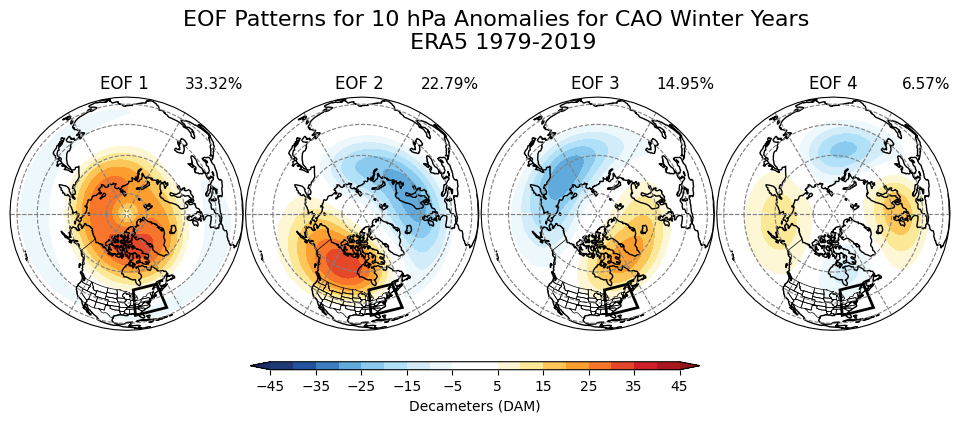

In [235]:
#Putting both plots on the same figure

# row_headers = ["EOF 1", "EOF 2"]

# Create subplot
fig, axs1 = plt.subplots(nrows=1, ncols=4, subplot_kw={'projection': ccrs.Orthographic(-90,90)}, figsize=(10, 8))

# clevs =[-550, -525, -500, -475, -450, -425, -400, -375, -350, -325, -300, -275, -250, -225, -200, -175, -150, -125, -100, -75, -50, -25, 25, 50, 75, 100,
#         125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550,]
clevs = np.arange(-45, 50, 5)
c_ticks = np.arange(-45, 50, 10)

# labels = [-21, -17, -13, -9, -5, -1, 1, 5, 9, 13, 17, 21]

cs4 = axs1[0].contourf(eofs['longitude'], 
                   eofs['latitude'], 
                   eofs_1,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[0].add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.5)
axs1[0].coastlines()
axs1[0].gridlines(linestyle = '--', color = 'grey')
axs1[0].set_title("EOF 1 ", loc = 'center')
axs1[0].set_title( "%.2f" % varfrac[0].data + '%', loc= 'right', fontsize= 11)
axs1[0].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))

cs5 = axs1[1].contourf(eofs['longitude'], 
                   eofs['latitude'], 
                   eofs_2,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[1].add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.5)
axs1[1].coastlines()
axs1[1].gridlines(linestyle = '--', color = 'grey')
axs1[1].set_title("EOF 2 ", loc = 'center')
axs1[1].set_title( "%.2f" % varfrac[1].data + '%' , loc= 'right', fontsize= 11)
axs1[1].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                               transform=ccrs.PlateCarree()))



cs6 = axs1[2].contourf(eofs['longitude'], 
                   eofs['latitude'], 
                   eofs_3,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[2].add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.5)
axs1[2].coastlines()
axs1[2].gridlines(linestyle = '--', color = 'grey')
axs1[2].set_title("EOF 3 ", loc = 'center')
axs1[2].set_title( "%.2f" % varfrac[2].data + '%' , loc= 'right', fontsize= 11)
axs1[2].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                               transform=ccrs.PlateCarree()))


cs8 = axs1[3].contourf(eofs['longitude'], 
                   eofs['latitude'], 
                   eofs_4,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[3].add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.5)
axs1[3].coastlines()
axs1[3].gridlines(linestyle = '--', color = 'grey')
axs1[3].set_title("EOF 4", loc = 'center')
axs1[3].set_title( "%.2f" % varfrac[3].data + '%' , loc= 'right', fontsize= 11)
axs1[3].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                               transform=ccrs.PlateCarree()))



fig.suptitle('EOF Patterns for 10 hPa Anomalies for CAO Winter Years \n ERA5 1979-2019', fontsize = 16, x=0.50, y = .75)
fig.subplots_adjust(left=0.01, right=0.95, wspace=0.01, hspace=0.01) 
#Colorbar(location, how far to bottom, how long,how tall)


# fig.subplots_adjust( wspace=0.01, hspace=-0.6)
#Colorbar(location, how far to bottom, how long,how tall)
cbar_ax = fig.add_axes([0.25, 0.3, 0.45, 0.01])
cbar=fig.colorbar(cs4, cax=cbar_ax, 
                  orientation='horizontal',
                  ticks = c_ticks, 
                  label='Decameters (DAM)',
                  extend = 'both', )

# cbar_ax = fig.add_axes([0.01, 0.01, 0.9, 0.03])
# cbar=fig.colorbar(cs4, cax=cbar_ax, orientation='horizontal', ticks = clevs, label='Meters (m)', 
#                   extend = 'both', location = 'bottom')


# plt.savefig('/scratch/kbarrag/CAO/Cold Air Attempts/z100eof.png')

In [182]:
# from xlearn.cluster import KMeans
from sklearn.cluster import KMeans


np.random.seed(123)

# Define number of clusters
k = 10

# Perform k-means clustering
k_clus = KMeans( n_clusters=k, max_iter=500, n_init=50, random_state=123).fit(pcs_sel)

# Cluster labels for each sample
labels = k_clus.labels_

# Cluster centers
centers = k_clus.cluster_centers_


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb71c2f4940>
Traceback (most recent call last):
  File "/home/kbarrag/.conda/envs/clim_data/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kbarrag/.conda/envs/clim_data/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kbarrag/.conda/envs/clim_data/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kbarrag/.conda/envs/clim_data/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thread

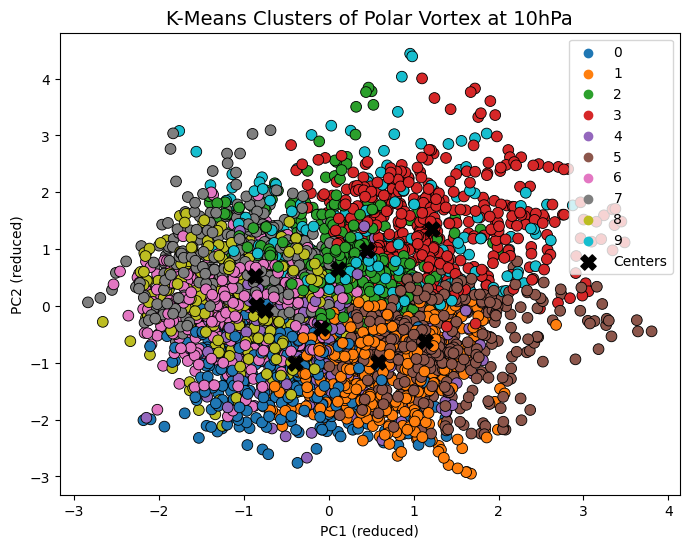

In [183]:
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import numpy as np

# # Assuming pcs_sel is (time, features)
# pcs_sel_np = pcs_sel.values
# np.random.seed(123)

# k = 10
# k_clus = KMeans(n_clusters=k, max_iter=500, n_init=50, random_state=123).fit(pcs_sel_np)
# labels = k_clus.labels_

# Reduce to 2D for visualization (like fviz_cluster does)
pca_2d = PCA(n_components=2)
pcs_2d = pca_2d.fit_transform(pcs_sel)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=pcs_2d[:,0], y=pcs_2d[:,1], hue=labels, palette="tab10", s=60, edgecolor="k")

# Plot cluster centers (projected to PCA space)
centers_2d = pca_2d.transform(k_clus.cluster_centers_)
plt.scatter(centers_2d[:,0], centers_2d[:,1], c="black", s=120, marker="X", label="Centers")

plt.title("K-Means Clusters of Polar Vortex at 10hPa", fontsize=14)
plt.xlabel("PC1 (reduced)")
plt.ylabel("PC2 (reduced)")
plt.legend()
plt.show()


In [187]:
# k_clus is your fitted KMeans object from sklearn
sizes = np.bincount(k_clus.labels_)
centers = k_clus.cluster_centers_

# Combine into a DataFrame
kmeans_basic_table = pd.DataFrame(
    centers,
    columns=[f"center_dim{i+1}" for i in range(centers.shape[1])]
)
kmeans_basic_table.insert(0, "size", sizes)

# Display
print(kmeans_basic_table)

   size  center_dim1  center_dim2  center_dim3  center_dim4
0   506    -0.501144     0.748923     0.157027    -1.204045
1   590    -0.757020    -0.797045    -0.703186    -0.346896
2   568     0.122547     0.299771     1.359493     0.254307
3   471     1.619272    -1.099186     0.514644    -0.176851
4   364     0.741448    -0.050612    -1.153514    -1.155917
5   627    -0.942869    -0.875154     0.834689    -0.273033
6   629     0.084808     0.379286    -1.209261     0.598319
7   721     0.667030     0.982145     0.107320    -0.034273
8   545    -0.807744     0.653822     0.149017     0.972637
9   273     0.069105    -1.099080    -0.497041     1.987814


In [188]:
cluster_djf = pd.DataFrame({
    "date": z10_anom_winter_pcap['time'],          # your datetime array (e.g., np.datetime64 or pandas.DatetimeIndex)
    "cluster": k_clus.labels_  # cluster labels from KMeans
})

cluster_djf

,date,cluster
0,1979-01-01,0
1,1979-01-02,0
2,1979-01-03,0
3,1979-01-04,0
4,1979-01-05,0
...,...,...
5289,2019-12-27,8
5290,2019-12-28,8
5291,2019-12-29,8
5292,2019-12-30,8


In [189]:

cluster_djf_xr = xr.Dataset(
    {"cluster": ("time", k_clus.labels_)},
    coords={ "time": z10_anom_winter_pcap['time']}
)
cluster_djf_xr


<xarray.Dataset>
Dimensions:  (time: 5294)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    cluster  (time) int32 0 0 0 0 0 0 0 0 1 1 1 1 1 ... 9 9 8 8 8 8 8 8 8 8 8 7

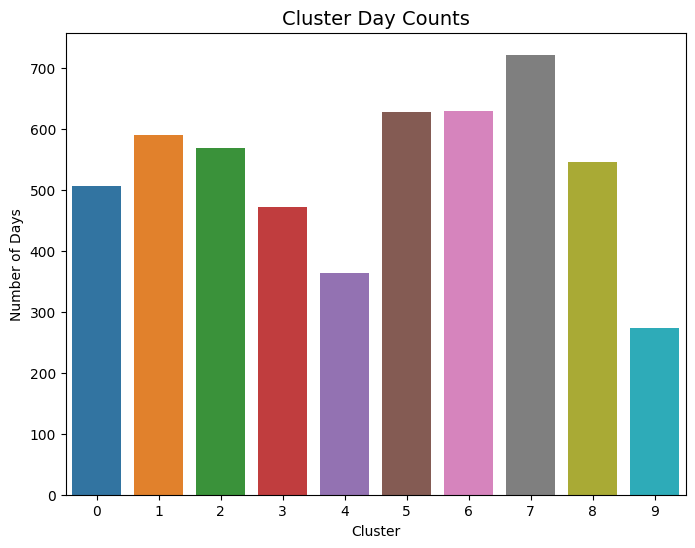

In [241]:

import seaborn as sns

# cluster_djf_xr: dims = time, variable = cluster


cluster_counts = cluster_djf_xr["cluster"].to_series().value_counts().sort_index()
# Convert to DataFrame for seaborn
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ["cluster", "count"]


plt.figure(figsize=(8,6))
sns.barplot(
    x="cluster",
    y="count",
    data=cluster_counts_df,
    # palette="viridis"
)
plt.title("Cluster Day Counts", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Number of Days")
plt.show()


In [190]:
# Assuming cluster_djf is the DataFrame we created earlier
cluster_djf = cluster_djf.sort_values("date")

events = []
for cluster, group in cluster_djf.groupby("cluster"):
    # Ensure dates are sorted
    group = group.sort_values("date").reset_index(drop=True)
    
    # Identify breaks > 1 day
    date_diff = np.diff(group["date"].values).astype("timedelta64[D]").astype(int)
    new_grp = np.concatenate(([0], np.cumsum(date_diff > 1)))

    # Assign group index
    group["grp"] = new_grp

    # Summarize each consecutive run
    summary = (
        group.groupby("grp")["date"]
        .agg(Start="min", End="max", Duration="count")
        .reset_index(drop=True)
    )
    summary["cluster"] = cluster
    events.append(summary)

cluster_events = pd.concat(events, ignore_index=True)
print(cluster_events.shape)


(949, 4)


In [191]:
cluster_events

,Start,End,Duration,cluster
0,1979-01-01,1979-01-08,8,0
1,1979-02-02,1979-02-05,4,0
2,1979-02-08,1979-02-14,7,0
3,1979-11-18,1979-11-18,1,0
4,1980-01-16,1980-01-17,2,0
...,...,...,...,...
944,2016-12-17,2016-12-18,2,9
945,2017-01-16,2017-01-18,3,9
946,2018-02-06,2018-02-11,6,9
947,2018-11-17,2018-11-26,10,9


In [192]:


# Sort by date
cluster_djf = cluster_djf.sort_values("date")

events = []
for cluster, group in cluster_djf.groupby("cluster"):
    group = group.sort_values("date").reset_index(drop=True)
    
    # Compute gaps between dates
    date_diff = np.diff(group["date"].values).astype("timedelta64[D]").astype(int)
    new_grp = np.concatenate(([0], np.cumsum(date_diff > 1)))

    # Assign group indices
    group["grp"] = new_grp

    # Summarize each run
    summary = (
        group.groupby("grp")["date"]
        .agg(Start="min", End="max", Duration="count")
        .reset_index(drop=True)
    )
    summary["cluster"] = cluster
    events.append(summary)

# Combine all clusters
cluster_events = pd.concat(events, ignore_index=True)

# Filter: keep only events lasting 5+ days
cluster_events = cluster_events[cluster_events["Duration"] >= 5].reset_index(drop=True)

print(cluster_events.shape)
(cluster_events)


(416, 4)


,Start,End,Duration,cluster
0,1979-01-01,1979-01-08,8,0
1,1979-02-08,1979-02-14,7,0
2,1980-12-31,1981-01-17,18,0
3,1982-11-04,1982-11-09,6,0
4,1982-12-08,1982-12-22,15,0
...,...,...,...,...
411,2014-02-01,2014-02-09,9,9
412,2015-01-01,2015-01-05,5,9
413,2015-01-13,2015-01-17,5,9
414,2018-02-06,2018-02-11,6,9


In [193]:
cluster_counts = (
    cluster_events
    .groupby("cluster", as_index=False)["Duration"]
    .sum()
    .rename(columns={"Duration": "n_days"})
)

cluster_counts


,cluster,n_days
0,0,326
1,1,450
2,2,466
3,3,437
4,4,242
5,5,525
6,6,472
7,7,554
8,8,358
9,9,193


In [194]:
# Get number of rows (events)
cluster_index = cluster_events.shape[0]

# cluster_events is a pandas DataFrame
# Filter by each cluster ID
cluster1_events  = cluster_events[cluster_events["cluster"] == 0]
cluster2_events  = cluster_events[cluster_events["cluster"] == 1]
cluster3_events  = cluster_events[cluster_events["cluster"] == 2]
cluster4_events  = cluster_events[cluster_events["cluster"] == 3]
cluster5_events  = cluster_events[cluster_events["cluster"] == 4]
cluster6_events  = cluster_events[cluster_events["cluster"] == 5]
cluster7_events  = cluster_events[cluster_events["cluster"] == 6]
cluster8_events  = cluster_events[cluster_events["cluster"] == 7]
cluster9_events  = cluster_events[cluster_events["cluster"] == 8]
cluster10_events = cluster_events[cluster_events["cluster"] == 9]

print(cluster1_events.shape)


(43, 4)


In [195]:
cluster_event_dict = {
    i: cluster_events[cluster_events["cluster"] == i]
    for i in sorted(cluster_events["cluster"].unique())
}

# Access like:
print(cluster_event_dict[1])

        Start        End  Duration  cluster
43 1979-01-09 1979-01-13         5        1
44 1979-03-19 1979-03-31        13        1
45 1980-01-11 1980-01-15         5        1
46 1980-01-22 1980-02-09        19        1
47 1980-12-07 1980-12-13         7        1
48 1982-01-13 1982-01-18         6        1
49 1982-03-05 1982-03-17        13        1
50 1982-11-24 1982-11-28         5        1
51 1985-11-19 1985-12-21        33        1
52 1986-02-22 1986-02-28         7        1
53 1986-11-01 1986-11-13        13        1
54 1986-12-13 1986-12-20         8        1
55 1987-03-16 1987-03-31        16        1
56 1988-01-31 1988-02-05         6        1
57 1988-12-17 1988-12-21         5        1
58 1993-03-15 1993-03-28        14        1
59 1994-01-24 1994-01-28         5        1
60 1996-01-13 1996-01-17         5        1
61 1996-12-27 1996-12-31         5        1
62 1997-01-23 1997-01-28         6        1
63 1997-02-13 1997-02-20         8        1
64 1999-11-15 1999-11-19        

In [196]:

def get_indices(cluster_events, time_vector):
    """
    Returns the indices in time_vector that correspond to all days
    in the cluster_events (Start-End ranges).
    
    cluster_events: pd.DataFrame with Start and End columns (datetime64)
    time_vector: np.array or pandas.DatetimeIndex of times
    """
    cluster_dates = []
    for _, row in cluster_events.iterrows():
        # Generate all dates from Start to End (inclusive)
        dates = pd.date_range(start=row["Start"], end=row["End"], freq="D")
        cluster_dates.extend(dates)
    
    cluster_dates = pd.to_datetime(cluster_dates)
    
    # Find indices where time_vector matches cluster_dates
    indices = np.where(np.isin(time_vector, cluster_dates))[0]
    return indices




In [198]:
cluster1_indices = get_indices(cluster1_events, z10_anom_winter1['time'])

cluster1_geop = z10_anom_winter['geopotential'][cluster1_indices,:, :,]

# Example: cluster 2
cluster2_indices = get_indices(cluster2_events, z10_anom_winter1['time'])
cluster2_geop = z10_anom_winter['geopotential'][cluster2_indices,:, :,]

cluster3_indices = get_indices(cluster3_events, z10_anom_winter1['time'])
cluster3_geop = z10_anom_winter['geopotential'][cluster3_indices,:, :,]

cluster4_indices = get_indices(cluster4_events, z10_anom_winter1['time'])
cluster4_geop = z10_anom_winter['geopotential'][cluster4_indices,:, :,]

cluster5_indices = get_indices(cluster5_events, z10_anom_winter1['time'])
cluster5_geop = z10_anom_winter['geopotential'][cluster5_indices,:, :,]

cluster6_indices = get_indices(cluster6_events, z10_anom_winter1['time'])
cluster6_geop = z10_anom_winter['geopotential'][cluster6_indices,:, :,]

cluster7_indices = get_indices(cluster7_events, z10_anom_winter1['time'])
cluster7_geop = z10_anom_winter['geopotential'][cluster7_indices,:, :,]

cluster8_indices = get_indices(cluster8_events, z10_anom_winter1['time'])
cluster8_geop = z10_anom_winter['geopotential'][cluster8_indices,:, :,]

cluster9_indices = get_indices(cluster9_events, z10_anom_winter1['time'])
cluster9_geop = z10_anom_winter['geopotential'][cluster9_indices,:, :,]

cluster10_indices = get_indices(cluster10_events, z10_anom_winter1['time'])
cluster10_geop = z10_anom_winter['geopotential'][cluster10_indices,:, :,]

In [199]:
c = cluster1_geop.mean(dim="time") 
cluster2_geop_mean = cluster2_geop.mean(dim="time") 
cluster3_geop_mean = cluster3_geop.mean(dim="time") 
cluster4_geop_mean = cluster4_geop.mean(dim="time") 
cluster5_geop_mean = cluster5_geop.mean(dim="time") 
cluster6_geop_mean = cluster6_geop.mean(dim="time")
cluster7_geop_mean = cluster7_geop.mean(dim="time")
cluster8_geop_mean = cluster8_geop.mean(dim="time")
cluster9_geop_mean = cluster9_geop.mean(dim="time")
cluster10_geop_mean = cluster10_geop.mean(dim="time")
cluster6_geop_mean

<xarray.DataArray 'geopotential' (latitude: 96, longitude: 360)>
array([[ -7.8996673,  -7.9038672,  -7.907889 , ...,  -7.8860846,
         -7.8908277,  -7.8954177],
       [ -9.305322 ,  -9.320475 ,  -9.334939 , ...,  -9.256458 ,
         -9.2733555,  -9.289632 ],
       [-10.682439 , -10.708558 , -10.733717 , ..., -10.597816 ,
        -10.627063 , -10.65523  ],
       ...,
       [  1.5796624,   1.5776051,   1.5801595, ...,   1.5675851,
          1.5689611,   1.5763319],
       [  1.5416857,   1.5383064,   1.543045 , ...,   1.5351962,
          1.5410672,   1.5448754],
       [  1.5193216,   1.5150614,   1.5198084, ...,   1.5023592,
          1.510758 ,   1.519454 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 89.62 88.62 87.62 86.62 ... -3.375 -4.375 -5.0
  * longitude  (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4

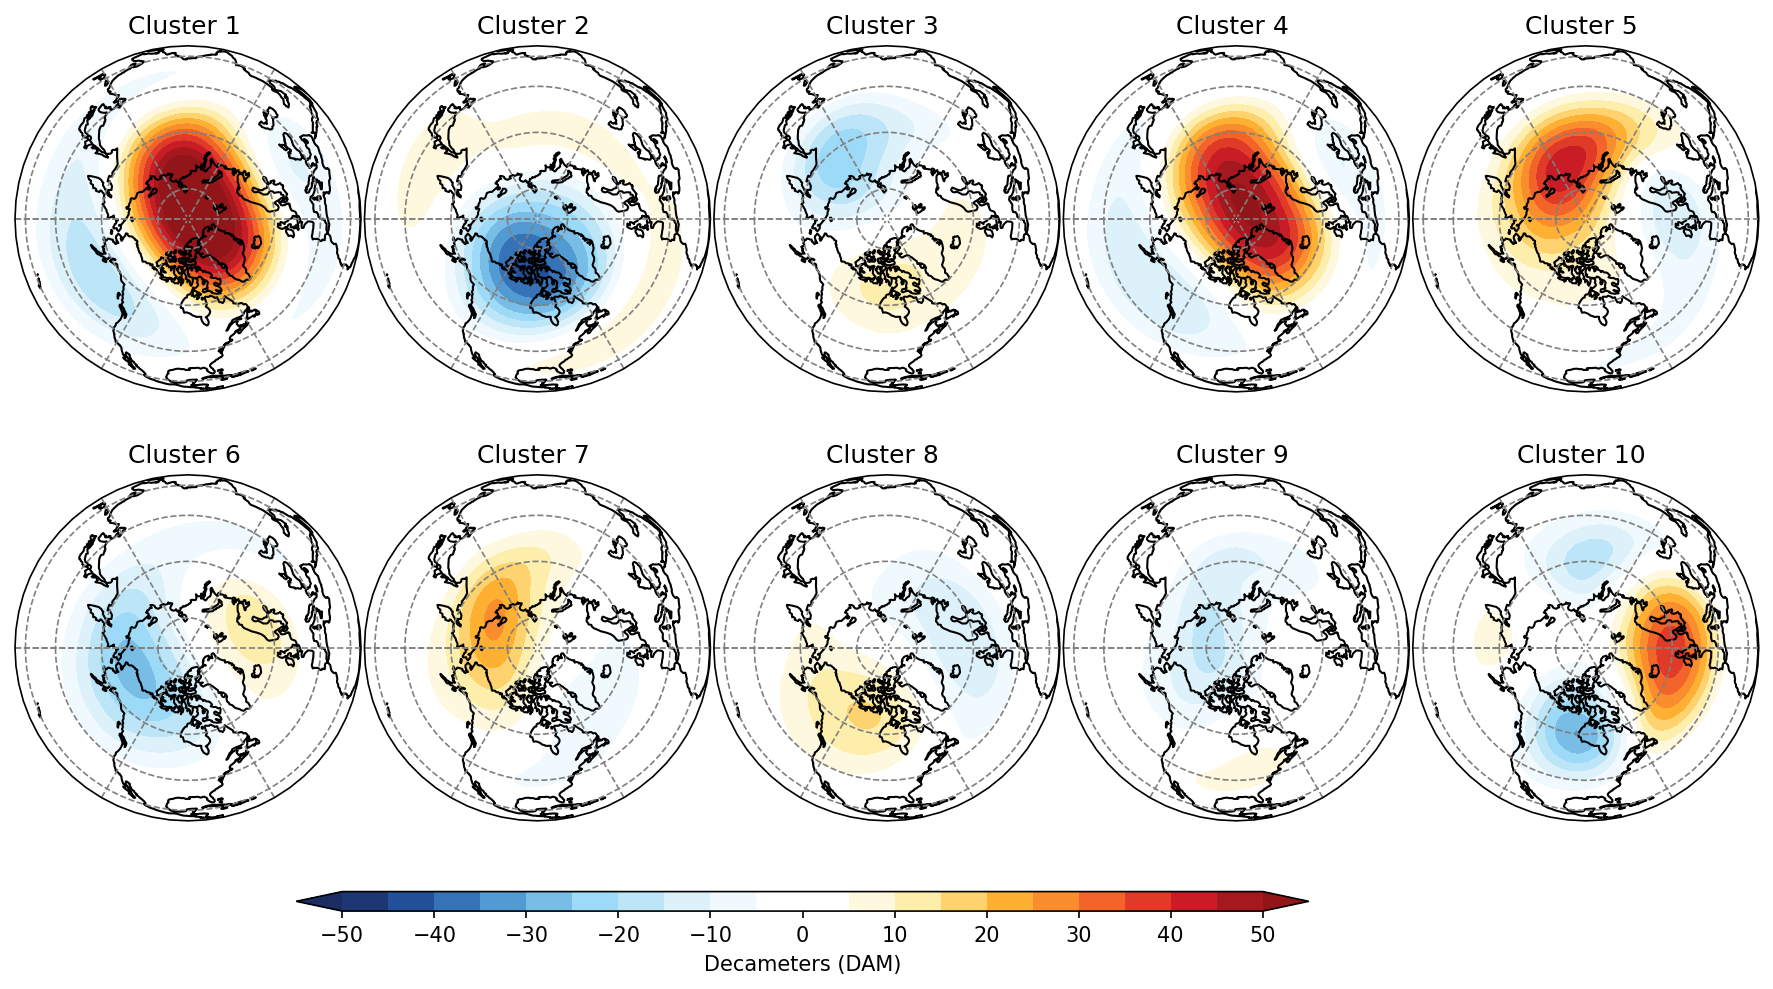

In [200]:
#Putting both plots on the same figure

# row_headers = ["EOF 1", "EOF 2"]
fig.suptitle('Composites of Z10 for Clusters 1–10 during Winter CAO Events' , fontsize = 16, x=0.48, y= .75)
# Create subplot
fig, axs1 = plt.subplots(nrows=2, ncols=5, subplot_kw={'projection': ccrs.Orthographic(-90,90)}, figsize=(15,13), dpi=150)

clevs = np.arange(-50, 55, 5) 
# clevs = np.arange(-500, 525, 25)
c_ticks = np.arange(-50, 60, 10)
# # labels = [-21, -17, -13, -9, -5, -1, 1, 5, 9, 13, 17, 21]

cs4 = axs1[0,0].contourf(cluster1_geop_mean['longitude'], 
                   cluster1_geop_mean['latitude'], 
                   cluster1_geop_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,0].coastlines()
axs1[0,0].gridlines(linestyle = '--', color = 'grey')
axs1[0,0].set_title("Cluster 1 ", loc = 'center')



cs5 = axs1[0,1].contourf(cluster2_geop_mean['longitude'], 
                   cluster2_geop_mean['latitude'], 
                   cluster2_geop_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,1].coastlines()
axs1[0,1].gridlines(linestyle = '--', color = 'grey')
axs1[0,1].set_title("Cluster 2 ", loc = 'center')


cs6 = axs1[0,2].contourf(cluster3_geop_mean['longitude'], 
                   cluster3_geop_mean['latitude'], 
                   cluster3_geop_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,2].coastlines()
axs1[0,2].gridlines(linestyle = '--', color = 'grey')
axs1[0,2].set_title("Cluster 3 ", loc = 'center')



cs7 = axs1[0,3].contourf(cluster4_geop_mean['longitude'], 
                   cluster4_geop_mean['latitude'], 
                   cluster4_geop_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[0,3].coastlines()
axs1[0,3].gridlines(linestyle = '--', color = 'grey')
axs1[0,3].set_title("Cluster 4 ", loc = 'center')



cs8 = axs1[0,4].contourf(cluster5_geop_mean['longitude'], 
                   cluster5_geop_mean['latitude'], 
                   cluster5_geop_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,4].coastlines()
axs1[0,4].gridlines(linestyle = '--', color = 'grey')
axs1[0,4].set_title("Cluster 5 ", loc = 'center')


cs9 = axs1[1,0].contourf(cluster6_geop_mean['longitude'], cluster6_geop_mean['latitude'], cluster6_geop_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,0].coastlines()
axs1[1,0].gridlines(linestyle = '--', color = 'grey')
axs1[1,0].set_title("Cluster 6 ", loc = 'center')


cs10 = axs1[1,1].contourf(cluster7_geop_mean['longitude'], cluster7_geop_mean['latitude'], cluster7_geop_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,1].coastlines()
axs1[1,1].gridlines(linestyle = '--', color = 'grey')
axs1[1,1].set_title("Cluster 7 ", loc = 'center')

cs11 = axs1[1,2].contourf(cluster8_geop_mean['longitude'], cluster8_geop_mean['latitude'], cluster8_geop_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,2].coastlines()
axs1[1,2].gridlines(linestyle = '--', color = 'grey')
axs1[1,2].set_title("Cluster 8 ", loc = 'center')


cs12 = axs1[1,3].contourf(cluster9_geop_mean['longitude'], cluster9_geop_mean['latitude'], cluster9_geop_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,3].coastlines()
axs1[1,3].gridlines(linestyle = '--', color = 'grey')
axs1[1,3].set_title("Cluster 9 ", loc = 'center')

cs13 = axs1[1,4].contourf(cluster10_geop_mean['longitude'], cluster10_geop_mean['latitude'], cluster10_geop_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,4].coastlines()
axs1[1,4].gridlines(linestyle = '--', color = 'grey')
axs1[1,4].set_title("Cluster 10 ", loc = 'center')



# fig.suptitle('EOF Patterns for 10 hPa Anomalies for CAO Winter Years- ERA5 1979-2019', fontsize = 16, x=0.55, y = .9)
# fig.subplots_adjust( wspace=0.01, hspace=-0.9)
fig.subplots_adjust( wspace=0.01, hspace=-0.6)
#Colorbar(location, how far to bottom, how long,how tall)
cbar_ax = fig.add_axes([0.25, 0.25, 0.45, 0.01])
cbar=fig.colorbar(cs4, cax=cbar_ax, 
                  orientation='horizontal',
                  ticks = c_ticks, 
                  label='Decameters (DAM)',
                  extend = 'both', )

# cbar_ax = fig.add_axes([0.01, 0.01, 0.9, 0.03])
# cbar=fig.colorbar(cs4, cax=cbar_ax, orientation='horizontal', ticks = clevs, label='Meters (m)', 
#                   extend = 'both', location = 'bottom')


# plt.savefig('/scratch/kbarrag/CAO/Cold Air Attempts/z100eof.png')

In [204]:
cluster1_indices = get_indices(cluster1_events, t2m_anom_winter1['time'])
cluster1_t2m = t2m_anom_winter['2m_temperature'][cluster1_indices,:, :,]

# Example: cluster 2
cluster2_indices = get_indices(cluster2_events, t2m_anom_winter1['time'])
cluster2_t2m = t2m_anom_winter['2m_temperature'][cluster2_indices,:, :,]

cluster3_indices = get_indices(cluster3_events, t2m_anom_winter1['time'])
cluster3_t2m = t2m_anom_winter['2m_temperature'][cluster3_indices,:, :,]

cluster4_indices = get_indices(cluster4_events, t2m_anom_winter1['time'])
cluster4_t2m = t2m_anom_winter['2m_temperature'][cluster4_indices,:, :,]

cluster5_indices = get_indices(cluster5_events, t2m_anom_winter1['time'])
cluster5_t2m = t2m_anom_winter['2m_temperature'][cluster5_indices,:, :,]

cluster6_indices = get_indices(cluster6_events, t2m_anom_winter1['time'])
cluster6_t2m = t2m_anom_winter['2m_temperature'][cluster6_indices,:, :,]

cluster7_indices = get_indices(cluster7_events, t2m_anom_winter1['time'])
cluster7_t2m = t2m_anom_winter['2m_temperature'][cluster7_indices,:, :,]

cluster8_indices = get_indices(cluster8_events, t2m_anom_winter1['time'])
cluster8_t2m = t2m_anom_winter['2m_temperature'][cluster8_indices,:, :,]

cluster9_indices = get_indices(cluster9_events, t2m_anom_winter1['time'])
cluster9_t2m = t2m_anom_winter['2m_temperature'][cluster9_indices,:, :,]

cluster10_indices = get_indices(cluster10_events, t2m_anom_winter1['time'])
cluster10_t2m = t2m_anom_winter['2m_temperature'][cluster10_indices,:, :,]

In [205]:
time_ix = np.isin(cluster1_t2m.time, era5_ones.time)
cluster1_t2m1 = cluster1_t2m.sel(time=time_ix)

time_ix = np.isin(cluster2_t2m.time, era5_ones.time)
cluster2_t2m1 = cluster2_t2m.sel(time=time_ix)

time_ix = np.isin(cluster3_t2m.time, era5_ones.time)
cluster3_t2m1 = cluster3_t2m.sel(time=time_ix)

time_ix = np.isin(cluster4_t2m.time, era5_ones.time)
cluster4_t2m1 = cluster4_t2m.sel(time=time_ix)

time_ix = np.isin(cluster5_t2m.time, era5_ones.time)
cluster5_t2m1 = cluster5_t2m.sel(time=time_ix)

time_ix = np.isin(cluster6_t2m.time, era5_ones.time)
cluster6_t2m1 = cluster6_t2m.sel(time=time_ix)

time_ix = np.isin(cluster7_t2m.time, era5_ones.time)
cluster7_t2m1 = cluster7_t2m.sel(time=time_ix)

time_ix = np.isin(cluster8_t2m.time, era5_ones.time)
cluster8_t2m1 = cluster8_t2m.sel(time=time_ix)

time_ix = np.isin(cluster9_t2m.time, era5_ones.time)
cluster9_t2m1 = cluster9_t2m.sel(time=time_ix)

time_ix = np.isin(cluster10_t2m.time, era5_ones.time)
cluster10_t2m1 = cluster10_t2m.sel(time=time_ix)

In [206]:
cluster1_t2m_mean = cluster1_t2m1.mean(dim="time") 
cluster2_t2m_mean = cluster2_t2m1.mean(dim="time") 
cluster3_t2m_mean = cluster3_t2m1.mean(dim="time") 
cluster4_t2m_mean = cluster4_t2m1.mean(dim="time") 
cluster5_t2m_mean = cluster5_t2m1.mean(dim="time") 
cluster6_t2m_mean = cluster6_t2m1.mean(dim="time")
cluster7_t2m_mean = cluster7_t2m1.mean(dim="time")
cluster8_t2m_mean = cluster8_t2m1.mean(dim="time")
cluster9_t2m_mean = cluster9_t2m1.mean(dim="time")
cluster10_t2m_mean = cluster10_t2m1.mean(dim="time")
cluster1_t2m_mean

<xarray.DataArray '2m_temperature' (latitude: 96, longitude: 360)>
array([[-2.9792917 , -2.980475  , -2.9816008 , ..., -2.9767485 ,
        -2.9775295 , -2.978447  ],
       [-2.7811508 , -2.786103  , -2.7913997 , ..., -2.768046  ,
        -2.7722278 , -2.7765799 ],
       [-2.5899222 , -2.5937052 , -2.5977747 , ..., -2.5740378 ,
        -2.5796328 , -2.58529   ],
       ...,
       [-0.25754434, -0.24231039, -0.23292114, ..., -0.26912192,
        -0.2852946 , -0.28278524],
       [-0.27785483, -0.24620849, -0.24658163, ..., -0.30372965,
        -0.31123453, -0.27085695],
       [-0.24581869, -0.24138102, -0.25826862, ..., -0.29269573,
        -0.27439576, -0.24927042]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 89.62 88.62 87.62 86.62 ... -3.375 -4.375 -5.0
  * longitude  (longitude) float32 -179.6 -178.6 -177.6 ... 177.4 178.4 179.4

In [208]:
cluster1_indices = get_indices(cluster1_events, t2m_winter1['time'])
cluster1_t2m_w = t2m_winter1['2m_temperature'][cluster1_indices,:, :,]

# Example: cluster 2
cluster2_indices = get_indices(cluster2_events, t2m_winter1['time'])
cluster2_t2m_w = t2m_winter1['2m_temperature'][cluster2_indices,:, :,]

cluster3_indices = get_indices(cluster3_events, t2m_winter1['time'])
cluster3_t2m_w = t2m_winter1['2m_temperature'][cluster3_indices,:, :,]

cluster4_indices = get_indices(cluster4_events, t2m_winter1['time'])
cluster4_t2m_w = t2m_winter1['2m_temperature'][cluster4_indices,:, :,]

cluster5_indices = get_indices(cluster5_events, t2m_winter1['time'])
cluster5_t2m_w = t2m_winter1['2m_temperature'][cluster5_indices,:, :,]

cluster6_indices = get_indices(cluster6_events, t2m_winter1['time'])
cluster6_t2m_w = t2m_winter1['2m_temperature'][cluster6_indices,:, :,]

cluster7_indices = get_indices(cluster7_events, t2m_winter1['time'])
cluster7_t2m_w = t2m_winter1['2m_temperature'][cluster7_indices,:, :,]

cluster8_indices = get_indices(cluster8_events, t2m_winter1['time'])
cluster8_t2m_w = t2m_winter1['2m_temperature'][cluster8_indices,:, :,]

cluster9_indices = get_indices(cluster9_events, t2m_winter1['time'])
cluster9_t2m_w = t2m_winter1['2m_temperature'][cluster9_indices,:, :,]

cluster10_indices = get_indices(cluster10_events, t2m_winter1['time'])
cluster10_t2m_w = t2m_winter1['2m_temperature'][cluster10_indices,:, :,]

In [209]:
time_ix = np.isin(cluster1_t2m_w.time, era5_ones.time)
cluster1_t2m1_w = cluster1_t2m_w.sel(time=time_ix)

time_ix = np.isin(cluster2_t2m.time, era5_ones.time)
cluster2_t2m1_w = cluster2_t2m_w.sel(time=time_ix)

time_ix = np.isin(cluster3_t2m_w.time, era5_ones.time)
cluster3_t2m1_w = cluster3_t2m.sel(time=time_ix)

time_ix = np.isin(cluster4_t2m_w.time, era5_ones.time)
cluster4_t2m1_w = cluster4_t2m.sel(time=time_ix)

time_ix = np.isin(cluster5_t2m_w.time, era5_ones.time)
cluster5_t2m1_w = cluster5_t2m.sel(time=time_ix)

time_ix = np.isin(cluster6_t2m_w.time, era5_ones.time)
cluster6_t2m1_w = cluster6_t2m.sel(time=time_ix)

time_ix = np.isin(cluster7_t2m_w.time, era5_ones.time)
cluster7_t2m1_w = cluster7_t2m.sel(time=time_ix)

time_ix = np.isin(cluster8_t2m_w.time, era5_ones.time)
cluster8_t2m1_w = cluster8_t2m.sel(time=time_ix)

time_ix = np.isin(cluster9_t2m_w.time, era5_ones.time)
cluster9_t2m1_w = cluster9_t2m.sel(time=time_ix)

time_ix = np.isin(cluster10_t2m_w.time, era5_ones.time)
cluster10_t2m1_w = cluster10_t2m.sel(time=time_ix)

In [250]:
cluster1_t2m_dc = cluster1_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster2_t2m_dc = cluster2_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster3_t2m_dc = cluster3_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster4_t2m_dc = cluster4_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster5_t2m_dc = cluster5_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster6_t2m_dc = cluster6_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster7_t2m_dc = cluster7_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster8_t2m_dc = cluster8_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster9_t2m_dc = cluster9_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()
cluster10_t2m_dc = cluster10_t2m_w.sel(longitude=slice(-85, -67),latitude=slice(49,29)).mean()

In [251]:
cluster1_t2m_dc.data

array(4.747753, dtype=float32)

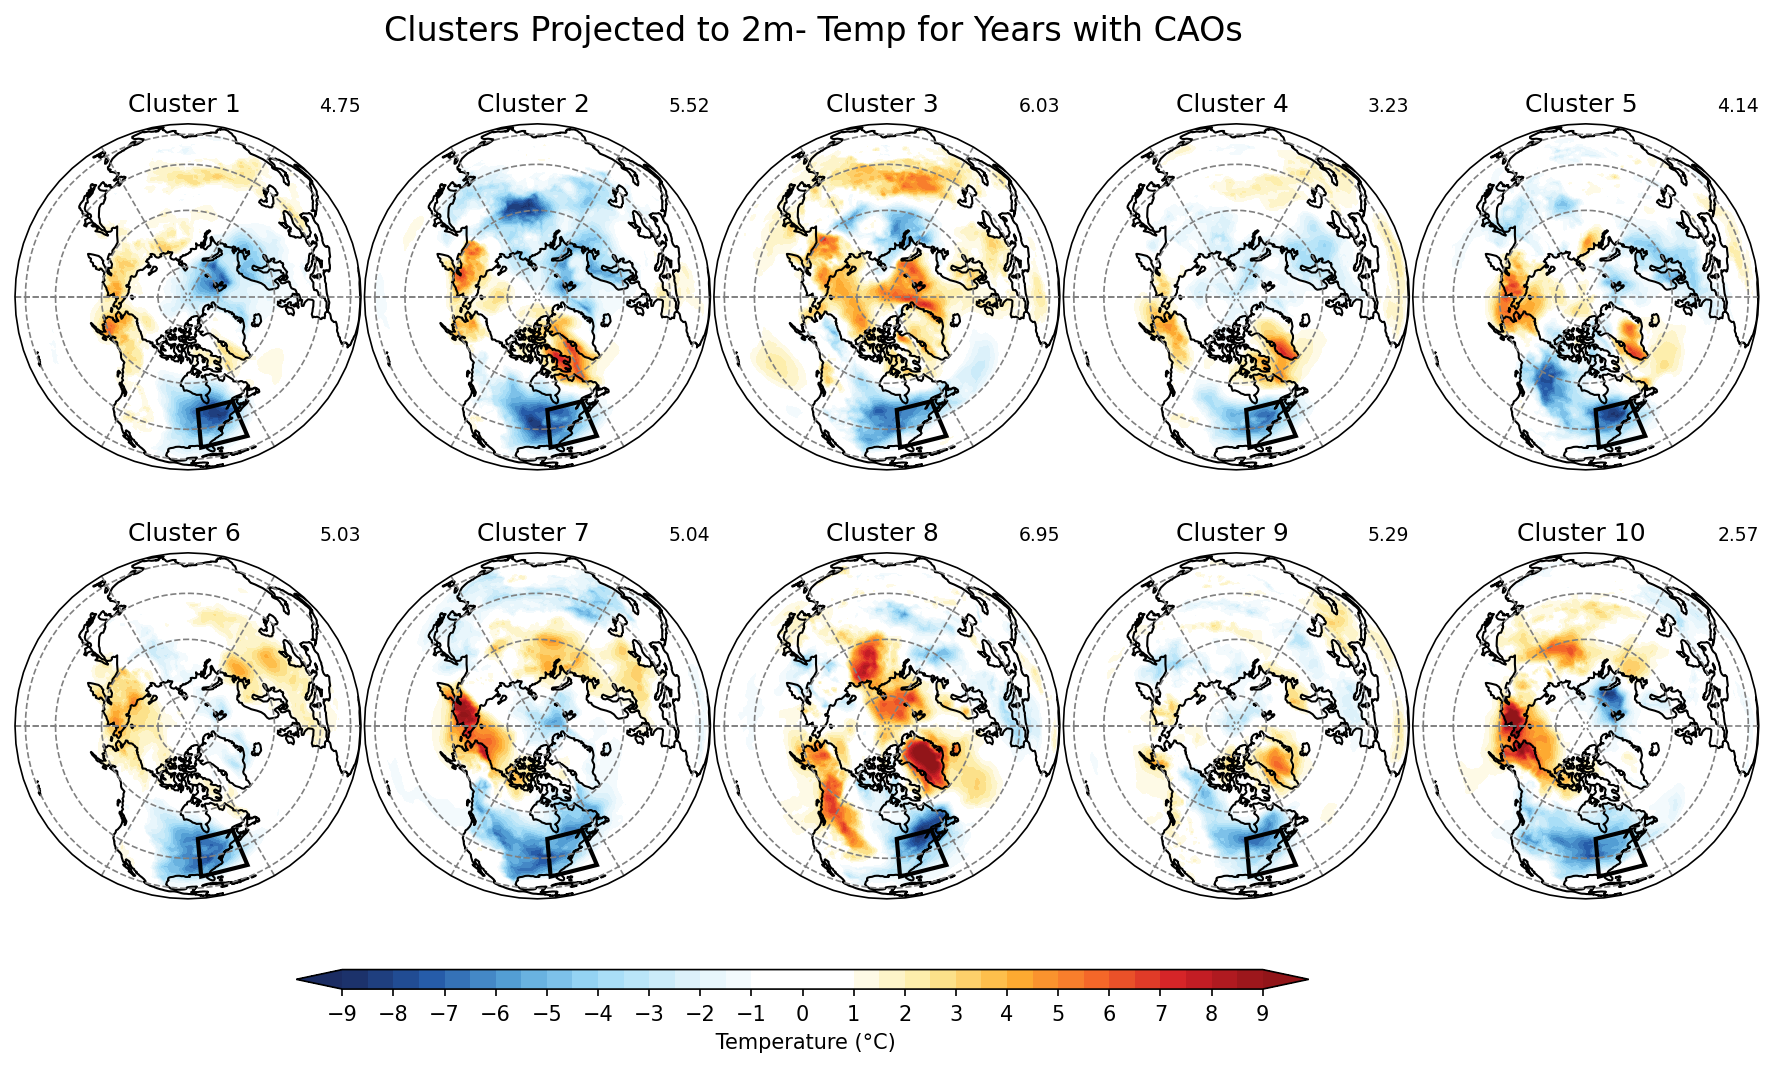

In [253]:
#Putting both plots on the same figure


# Create subplot
fig, axs1 = plt.subplots(nrows=2, ncols=5, subplot_kw={'projection': ccrs.Orthographic(-90,90)}, figsize=(15,13), dpi=150)
fig.suptitle('Clusters Projected to 2m- Temp for Years with CAOs' , fontsize = 16, x=0.48, y= .75)
clevs = np.arange(-9, 9.5, 0.5) 
# clevs = np.arange(-500, 525, 25)
c_ticks = np.arange(-9, 10, 1)
# # labels = [-21, -17, -13, -9, -5, -1, 1, 5, 9, 13, 17, 21]

cs4 = axs1[0,0].contourf(cluster1_t2m_mean['longitude'], cluster1_t2m_mean['latitude'], cluster1_t2m_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,0].coastlines()
axs1[0,0].gridlines(linestyle = '--', color = 'grey')
axs1[0,0].set_title("Cluster 1 ", loc = 'center')
axs1[0,0].set_title( "%.2f" % cluster1_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[0,0].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))




cs5 = axs1[0,1].contourf(cluster2_t2m_mean['longitude'], 
                   cluster2_t2m_mean['latitude'], 
                   cluster2_t2m_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,1].coastlines()
axs1[0,1].gridlines(linestyle = '--', color = 'grey')
axs1[0,1].set_title("Cluster 2 ", loc = 'center')
axs1[0,1].set_title( "%.2f" % cluster2_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[0,1].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))


cs6 = axs1[0,2].contourf(cluster3_t2m_mean['longitude'], 
                   cluster3_t2m_mean['latitude'], 
                   cluster3_t2m_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,2].coastlines()
axs1[0,2].gridlines(linestyle = '--', color = 'grey')
axs1[0,2].set_title("Cluster 3 ", loc = 'center')
axs1[0,2].set_title( "%.2f" % cluster3_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[0,2].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))



cs7 = axs1[0,3].contourf(cluster4_t2m_mean['longitude'], 
                   cluster4_t2m_mean['latitude'], 
                   cluster4_t2m_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())

axs1[0,3].coastlines()
axs1[0,3].gridlines(linestyle = '--', color = 'grey')
axs1[0,3].set_title("Cluster 4 ", loc = 'center')
axs1[0,3].set_title( "%.2f" % cluster4_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[0,3].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))



cs8 = axs1[0,4].contourf(cluster5_t2m_mean['longitude'], 
                   cluster5_t2m_mean['latitude'], 
                   cluster5_t2m_mean,
                   levels= clevs,
                   cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                   extend = 'both',
                   transform = ccrs.PlateCarree())
axs1[0,4].coastlines()
axs1[0,4].gridlines(linestyle = '--', color = 'grey')
axs1[0,4].set_title("Cluster 5 ", loc = 'center')
axs1[0,4].set_title( "%.2f" % cluster5_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[0,4].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))


cs9 = axs1[1,0].contourf(cluster6_t2m_mean['longitude'], cluster6_t2m_mean['latitude'], cluster6_t2m_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,0].coastlines()
axs1[1,0].gridlines(linestyle = '--', color = 'grey')
axs1[1,0].set_title("Cluster 6 ", loc = 'center')
axs1[1,0].set_title( "%.2f" % cluster6_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[1,0].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))



cs10 = axs1[1,1].contourf(cluster7_t2m_mean['longitude'], cluster7_t2m_mean['latitude'], cluster7_t2m_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,1].coastlines()
axs1[1,1].gridlines(linestyle = '--', color = 'grey')
axs1[1,1].set_title("Cluster 7 ", loc = 'center')
axs1[1,1].set_title( "%.2f" % cluster7_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[1,1].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))

cs11 = axs1[1,2].contourf(cluster8_t2m_mean['longitude'], cluster8_t2m_mean['latitude'], cluster8_t2m_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,2].coastlines()
axs1[1,2].gridlines(linestyle = '--', color = 'grey')
axs1[1,2].set_title("Cluster 8 ", loc = 'center')
axs1[1,2].set_title( "%.2f" % cluster8_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[1,2].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))


cs12 = axs1[1,3].contourf(cluster9_t2m_mean['longitude'], cluster9_t2m_mean['latitude'], cluster9_t2m_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,3].coastlines()
axs1[1,3].gridlines(linestyle = '--', color = 'grey')
axs1[1,3].set_title("Cluster 9 ", loc = 'center')
axs1[1,3].set_title( "%.2f" % cluster9_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[1,3].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))

cs13 = axs1[1,4].contourf(cluster10_t2m_mean['longitude'], cluster10_t2m_mean['latitude'], cluster10_t2m_mean,
                   levels= clevs, cmap= cmaps.BlueWhiteOrangeRed, #cmaps.temp_diff_18lev,
                    extend = 'both', transform = ccrs.PlateCarree())
axs1[1,4].coastlines()
axs1[1,4].gridlines(linestyle = '--', color = 'grey')
axs1[1,4].set_title("Cluster 10 ", loc = 'center')
axs1[1,4].set_title( "%.2f" % cluster10_t2m_dc.data + '', loc= 'right', fontsize= 9)
axs1[1,4].add_patch(mpatches.Rectangle(xy=[-85, 29], width=18.15, height=20,
                                facecolor='none', edgecolor='k', linewidth = 2,
                                transform=ccrs.PlateCarree()))



# fig.suptitle('EOF Patterns for 10 hPa Anomalies for CAO Winter Years- ERA5 1979-2019', fontsize = 16, x=0.55, y = .9)
# fig.subplots_adjust( wspace=0.01, hspace=-0.9)
fig.subplots_adjust( wspace=0.01, hspace=-0.6)
#Colorbar(location, how far to bottom, how long,how tall)
cbar_ax = fig.add_axes([0.25, 0.25, 0.45, 0.01])
cbar=fig.colorbar(cs4, cax=cbar_ax, 
                  orientation='horizontal',
                  ticks = c_ticks, 
                  label=' Temperature (°C)',
                  extend = 'both', )

# cbar_ax = fig.add_axes([0.01, 0.01, 0.9, 0.03])
# cbar=fig.colorbar(cs4, cax=cbar_ax, orientation='horizontal', ticks = clevs, label='Meters (m)', 
#                   extend = 'both', location = 'bottom')


# plt.savefig('/scratch/kbarrag/CAO/Cold Air Attempts/z100eof.png')

In [221]:

def pattern_corr(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    num = np.sum(p * q)
    denom = np.sqrt(np.sum(p**2) * np.sum(q**2))
    return num / denom

def pattern_corr_weighted(p, q, lat):

    p = np.asarray(p)
    q = np.asarray(q)
    lat = np.asarray(lat)

    nlat, nlon = p.shape
    if len(lat) != nlat:
        raise ValueError("Latitude length must match the first dimension of the data.")

    # Weight by cos(lat)
    w = np.cos(np.deg2rad(lat))
    w2d = np.repeat(w[:, np.newaxis], nlon, axis=1)

    # Weighted correlation
    p_mean = np.average(p, weights=w2d)
    q_mean = np.average(q, weights=w2d)
    num = np.sum(w2d * (p - p_mean) * (q - q_mean))
    denom = np.sqrt(np.sum(w2d * (p - p_mean)**2) * np.sum(w2d * (q - q_mean)**2))
    return num / denom


def corr_matrix(comps, weighted=False, lat=None):
    """
    Compute an (nclus x nclus) matrix of pattern correlations.

    Parameters
    ----------
    comps : list of 2D arrays or xr.DataArray
        Composite fields to compare.
    weighted : bool
        Whether to apply latitude weighting.
    lat : 1D array-like, optional
        Latitude values required if weighted=True.
    """
    nclus = len(comps)
    corr_mat = np.full((nclus, nclus), np.nan)

    for i in range(nclus):
        for j in range(nclus):
            if weighted:
                corr_mat[i, j] = pattern_corr_weighted(comps[i], comps[j], lat)
            else:
                corr_mat[i, j] = pattern_corr(comps[i], comps[j])

    return corr_mat


In [222]:
comps =  [cluster1_geop_mean, cluster2_geop_mean,cluster3_geop_mean, cluster4_geop_mean, cluster5_geop_mean, cluster6_geop_mean, 
             cluster7_geop_mean, cluster8_geop_mean, cluster9_geop_mean, cluster10_geop_mean]

lat_NH = np.array(cluster1_geop_mean['latitude'])  # e.g., from your dataset
lat_NH

array([89.625, 88.625, 87.625, 86.625, 85.625, 84.625, 83.625, 82.625,
       81.625, 80.625, 79.625, 78.625, 77.625, 76.625, 75.625, 74.625,
       73.625, 72.625, 71.625, 70.625, 69.625, 68.625, 67.625, 66.625,
       65.625, 64.625, 63.625, 62.625, 61.625, 60.625, 59.625, 58.625,
       57.625, 56.625, 55.625, 54.625, 53.625, 52.625, 51.625, 50.625,
       49.625, 48.625, 47.625, 46.625, 45.625, 44.625, 43.625, 42.625,
       41.625, 40.625, 39.625, 38.625, 37.625, 36.625, 35.625, 34.625,
       33.625, 32.625, 31.625, 30.625, 29.625, 28.625, 27.625, 26.625,
       25.625, 24.625, 23.625, 22.625, 21.625, 20.625, 19.625, 18.625,
       17.625, 16.625, 15.625, 14.625, 13.625, 12.625, 11.625, 10.625,
        9.625,  8.625,  7.625,  6.625,  5.625,  4.625,  3.625,  2.625,
        1.625,  0.625, -0.375, -1.375, -2.375, -3.375, -4.375, -5.   ],
      dtype=float32)

In [228]:
corr_mat_weighted = corr_matrix(comps, weighted=True, lat=lat_NH)
corr_mat_unweighted = corr_matrix(comps, weighted=False, lat=lat_NH)
corr_mat_weighted 

array([[ 1.        , -0.54388094, -0.25873908,  0.99291635,  0.61452579,
        -0.08601669,  0.37910604, -0.32257953, -0.65488929,  0.01645024],
       [-0.54388094,  0.99999994, -0.31993175, -0.47543666, -0.30508617,
         0.4960933 , -0.23842393, -0.4038212 ,  0.45588827,  0.2411616 ],
       [-0.25873908, -0.31993175,  1.        , -0.31196401, -0.73211366,
         0.31924972, -0.73863089,  0.15319256,  0.55226421,  0.12588865],
       [ 0.99291635, -0.47543672, -0.31196401,  1.        ,  0.61311865,
        -0.0614564 ,  0.37598136, -0.38510901, -0.64691144,  0.0583203 ],
       [ 0.61452579, -0.30508617, -0.7321136 ,  0.61311865,  1.        ,
        -0.60007179,  0.86967915,  0.12540773, -0.85015893, -0.41430029],
       [-0.08601667,  0.4960933 ,  0.31924972, -0.0614564 , -0.60007179,
         1.        , -0.72551835, -0.67118007,  0.60419899,  0.50184923],
       [ 0.37910604, -0.23842393, -0.73863089,  0.37598139,  0.86967915,
        -0.72551835,  1.        ,  0.25500968

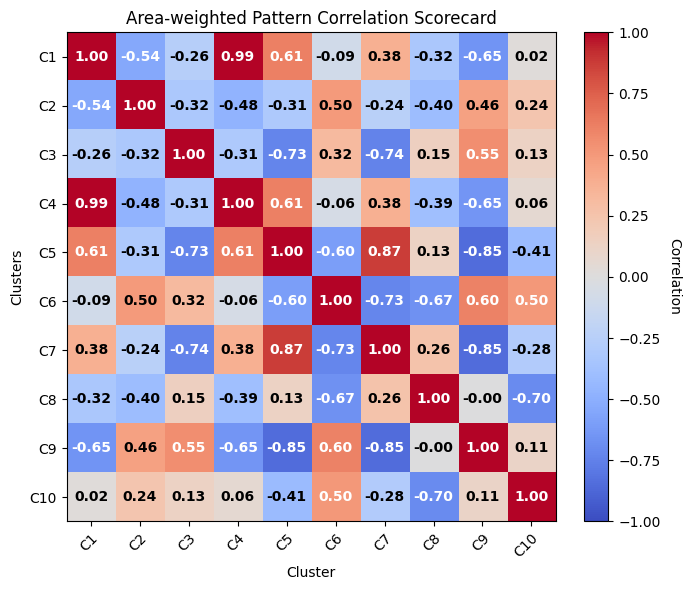

In [229]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_mat_weighted , cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Label axes
nclus = corr_mat_weighted.shape[0]
labels = [f"C{i+1}" for i in range(nclus)]
ax.set_xticks(np.arange(nclus))
ax.set_yticks(np.arange(nclus))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('Clusters')
ax.set_xlabel('Cluster')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add correlation values inside boxes
for i in range(nclus):
    for j in range(nclus):
        text_color = "black" if abs(corr_mat_weighted[i, j]) < 0.5 else "white"
        ax.text(
            j, i, f"{corr_mat_weighted[i, j]:.2f}",
            ha="center", va="center", color=text_color, fontsize=10, fontweight="bold"
        )

# Title and layout
ax.set_title("Area-weighted Pattern Correlation Scorecard")
plt.tight_layout()
plt.show()


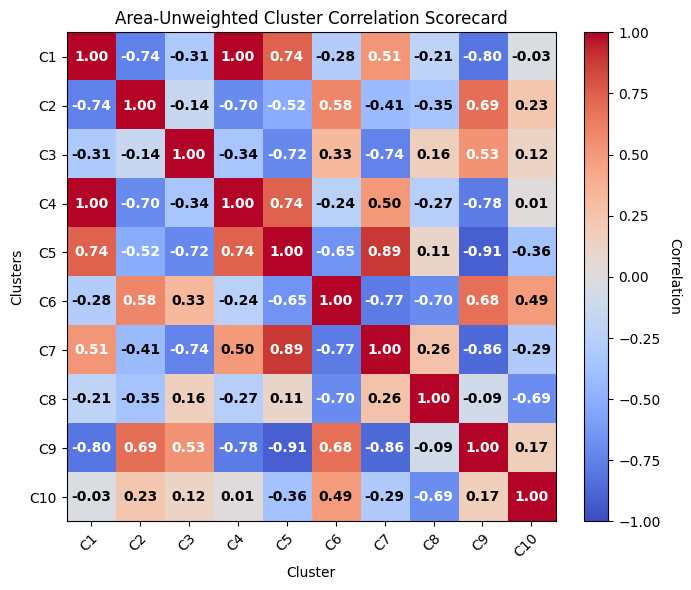

In [230]:

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_mat_unweighted , cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Label axes
nclus = corr_mat_unweighted.shape[0]
labels = [f"C{i+1}" for i in range(nclus)]
ax.set_xticks(np.arange(nclus))
ax.set_yticks(np.arange(nclus))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('Clusters')
ax.set_xlabel('Cluster')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add correlation values inside boxes
for i in range(nclus):
    for j in range(nclus):
        text_color = "black" if abs(corr_mat_unweighted[i, j]) < 0.5 else "white"
        ax.text(
            j, i, f"{corr_mat_unweighted[i, j]:.2f}",
            ha="center", va="center", color=text_color, fontsize=10, fontweight="bold"
        )

# Title and layout
ax.set_title("Area-Unweighted Cluster Correlation Scorecard")
plt.tight_layout()
plt.show()
